#Assignment 3 (Part II)



Install dependencies

In [ ]:
%rm -rf IndoorRobotEnv
!git clone https://github.com/luisgarrote/IndoorRobotEnv.git




In [ ]:
%cd IndoorRobotEnv

!pip install -r requirements.txt


Imports

In [ ]:
pip install -e .


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure

import gymnasium as gym
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random
from gymnasium import wrappers
import copy
from gymnasium.wrappers import RecordVideo

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from indoor_robot_2025_animated import IndoorRobot2025Env,ObservationMode
gym.register(
    id="IndoorRobot2025-v0",
    entry_point="indoor_robot_2025_animated:IndoorRobot2025Env",
)




Deep RL Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size
        self.counter = 0
        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []
        self.new_state_buffer = []
        self.terminal_buffer = []

    def store_tuples(self, state, action, reward, new_state, done):
        if len(self.state_buffer) < self.size:
            self.state_buffer.append(None)
            self.action_buffer.append(None)
            self.reward_buffer.append(None)
            self.new_state_buffer.append(None)
            self.terminal_buffer.append(None)

        self.counter = self.counter % self.size
        self.state_buffer[self.counter] = state
        self.action_buffer[self.counter] = action
        self.reward_buffer[self.counter] = reward
        self.new_state_buffer[self.counter] = new_state
        self.terminal_buffer[self.counter] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch=[];
        action_batch=[];
        reward_batch=[];
        new_state_batch=[];
        done_batch=[];

        for a in batch:
            state_batch.append(self.state_buffer[a])
            action_batch.append(self.action_buffer[a])
            reward_batch.append(self.reward_buffer[a])
            new_state_batch.append(self.new_state_buffer[a])
            done_batch.append(self.terminal_buffer[a])
        return state_batch, action_batch, reward_batch, new_state_batch, done_batch





Default DQN arquitecture

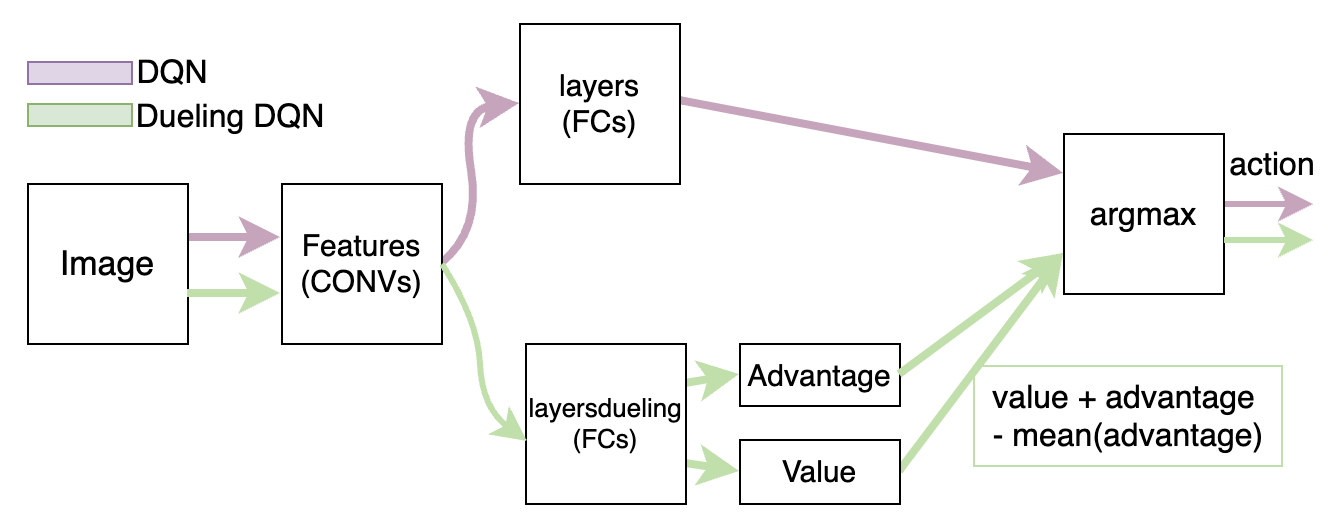

In [ ]:
from torchvision import datasets, models
class DQN(nn.Module):



    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()

        self.input_size=inputs;
        self.output_size=outputs;

TODO


###### DQN/Double DQN configuration

###########    ############    #################
#         #    #          #    #               #
#   IMG   # -> # features # -> #     layers    #    .... argmax ....
#         #    #  (CONVs) #    #     (FCs)     #
###########    ############    #################


###### Dueling configuration
                                                    #############
###########    ############    #################    # advantage #
#         #    #          #    #               # -> #############   ... value + advantage  - advantage.mean() ... argmax ...
#   IMG   # -> # features # -> # layersdueling # -> #############
#         #    #  (CONVs) #    #     (FCs)     #    #   value   #
###########    ############    #################    #############


    def forward(self, x):

         TODO

    def policy(self,state):
       with torch.no_grad():
            return self.__call__(state.unsqueeze(0)).argmax()

    def getPolicy(self,state,eps_threshold):
        sample = random.random()
        if sample > eps_threshold:
            with torch.no_grad():
                return self.__call__(state.unsqueeze(0)).argmax()
        else:
            return  torch.tensor(random.randrange(self.output_size), device=device, dtype=torch.long)


In [ ]:
from IPython.display import HTML
HTML('<iframe width="1297" height="778" src="https://www.youtube.com/embed/n5pYe9D2-iU" title="APA2025 - IndoorRobot2025Env demo" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>')



IndoorRobot2025Env Environment
[Sample result](https://youtu.be/n5pYe9D2-iU)

###    Description:
        Continuous or discrete control task to learn from pixels, a top-down racing environment.
###    Observation:
        Type: Image (96x96x3)
        Some indicators are shown at the bottom of the window along with the state RGB buffer. From left to right: the true speed, four ABS sensors, the steering wheel position and gyroscope.
###    Actions:
        Discrete Mode: 'nothing','left','right','gas','brake'
        Continuous Mode: 3 different variables can be modified: steering wheel, gas, and brake. For the methods explored in this Colab, discrete control commands are reasonable (a set of control commands is provided for this mode).
###    Episode Termination:
        Robot collides.
        Car accumulated a negative reward after given iterations (see ResetCounter and InitCounter).
        Episode length is greater than 1000.
        All tiles are visited.
###     Solved Requirements:
        The game is solved when the agent consistently gets 900+ points. For this assignment a minimum of 200 points are required.


DQN movie generation (for visual evaluation in Google Colab)

In [ ]:

def createMovie(Network,obs_mode):

    env1 = gym.make("IndoorRobot2025-v0", render_mode="rgb_array", observation_mode=obs_mode)
    envX = env1
    envX = RecordVideo(env1, video_folder='./videos/default',  episode_trigger = lambda x: True)

    new_state,_ = envX.reset()


    #print(new_state.shape)
    #print(new_state)
    stackedStateX=[new_state for i in range(FrameStack)];
    #print(stackedStateX.shape)

    state =torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,InputShape,1)) ).float().to(device)


    i=0
    Network.eval()
    resetStatus=0;


    while True:
        envX.render()
        #print(state)
        action = Network.policy(state.view(-1).unsqueeze(0));
        reward=0
        for x in range(ControlSteps):
            new_state, r, done, truncated, _  = envX.step(action.item())
            reward+=r
            if(done or truncated):
                break
        stackedStateX.pop(0)


        stackedStateX.append(new_state.copy())
        state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,InputShape,1 ))).float().to(device)
        i=i+1;
        if done or truncated:
          break;

    envX.close()
    env1.close();
    Network.train()
    mp4list = glob.glob('./videos/default/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

Dummy Net with random policy

In [ ]:
class RandomNet(nn.Module):

    def __init__(self,outputs):
        super(RandomNet, self).__init__()
        self.output_size=outputs;


    def forward(self, x):
        return  x

    def policy(self,state):
       return  torch.tensor([[random.randrange(self.output_size)]], device=device, dtype=torch.long)



Parameters

In [ ]:
n_actions=10

#hyper-parameters
TotalEpisodes=500;
MaxSteps=1000;
ControlSteps=1; # number of iterations the same action is executed in the environment
FrameStack=1 # number of consecutive frames used to represent the state
FreezeCounter=50; # clone the model every X episodes
BatchSize=64;
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.985
discount_factor=0.95
LearningRate=0.0001

SaveAtCounter=50 # save model or video at every X episodes
ResetCounter=30 # maximum number of experiences with bad performance (max=InitCounter+ResetCounter)
InitCounter=30 # minimum number of experiences per episode
FrameSize=1;

BufferSize=15000  # max number of experiences in the buffer (may need to be smaller if CUDA memory errors occur).

# use these flags to enable Double DQN and Duelinng (Dueling DQN or Double Dueling DQN)
usedoubleDQN=False
useDueling=False



Run the new netwwork with random policy

In [ ]:
InputShape=4
randomnet=RandomNet(n_actions)
createMovie(randomnet,ObservationMode.DIRECTION_AND_ERROR)

Initialization and Parameters:


In [ ]:

mode=ObservationMode.DIRECTION_AND_ERROR
env = gym.make("IndoorRobot2025-v0", render_mode="ignore_mode",observation_mode=mode)


if mode==ObservationMode.POSE:
     InputShape=3
elif mode == ObservationMode.DIRECTION:
     InputShape=3
elif  mode == ObservationMode.POSE_AND_ERROR:
     InputShape=4
elif mode == ObservationMode.DIRECTION_AND_ERROR:
     InputShape=4
elif mode == ObservationMode.LOCAL:
     InputShape=env.local_grid_size*env.local_grid_size




#network DQN


policy_net = DQN(InputShape*FrameStack, n_actions).to(device)
target_net = DQN(InputShape*FrameStack, n_actions).to(device)


target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

buffer = ReplayBuffer(BufferSize);

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)
loss=  torch.nn.SmoothL1Loss()

DQN training

In [ ]:
def trainModel(buffer_data):
    if buffer_data.counter < BatchSize:
        return 0.0

    state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer_data.sample_buffer(BatchSize)
    state_batch = torch.stack(state_batch).to(device)
    action_batch = torch.stack(action_batch).reshape(-1,1).to(device)
    new_state_batch = torch.stack(new_state_batch).to(device)
    reward_batch = torch.stack(reward_batch).reshape(-1,1).to(device)
    done_batch = torch.stack(done_batch).reshape(-1,1).to(device)


    TODO



In [ ]:
loss_val,scores, episodes,events, avg_scores,avg_scores20,exploration = [],[],[], [],[], [], []

bestScore=-99999;
at=0;


for f in range(TotalEpisodes):
    done  = False
    score = 0.0
    tloss = 0.0

    new_state,_=env.reset()#,seed=6)


    stackedState=[new_state for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedState),(FrameSize*FrameStack,InputShape,1)) ).float().to(device)

    if f % FreezeCounter == 0:
       print("########################################"+str(f)+" of "+str(TotalEpisodes))
       target_net.load_state_dict(policy_net.state_dict())

    if f % SaveAtCounter == 0:
       createMovie(policy_net,mode)

    resetStatus=0;
    i=0

    for F in range(MaxSteps):
        #env.render()
        #print(state)
        action = policy_net.getPolicy(state.view(-1).unsqueeze(0),exploration_threshold)

        reward=0
        for _ in range(ControlSteps):
            new_state, r, done,trunc, info = env.step(action.item())
            reward+=r
            i=i+1
            if(done or trunc):
                break
        if reward<0 and i>InitCounter:
            resetStatus=resetStatus+1;
        else:
            resetStatus=0

        stackedState.pop(0)
        stackedState.append(new_state.copy())

        new_state=torch.from_numpy(np.reshape(np.array(stackedState),(FrameSize*FrameStack,InputShape,1))).float().to(device)

        score += reward
        if(F<(MaxSteps-1)):
            buffer.store_tuples(state, action, torch.tensor(reward), new_state, torch.tensor(int(done)))

        state = new_state
        trainModel(buffer)


        if(done or trunc or resetStatus>=ResetCounter):
            break
    exploration_threshold= exploration_threshold*exploration_decay if exploration_threshold > exploration_threshold_min else exploration_threshold_min

    if(score>bestScore):
        print("Best EP: ",score," It: ",F*ControlSteps)
        bestScore=score;
        torch.save(policy_net.state_dict(), "BestIndoorRobot_best_model.ckpt")
        at=f;

    exploration.append(exploration_threshold)
    scores.append(score)
    episodes.append(f)
    events.append(F)
    avg_scores.append(score/F)
    avg_scores20.append(np.mean(scores[-20:]))




Plot performance

In [ ]:
figure(figsize=(12, 6), dpi=80)
plt.plot(episodes, scores)
plt.plot(episodes, events)
plt.plot(episodes, avg_scores)
plt.plot(episodes, avg_scores20)
plt.plot(episodes, exploration)
plt.xlabel('episodes')
plt.ylabel('y axis label')

plt.title('Track Locked DQN '+str(usedoubleDQN)+' '+str(useDueling))
plt.legend(['scores', 'events', 'avg_scores', 'avg_scores20','exploration'])
plt.show()

View Best Results

In [ ]:
policy_net.load_state_dict(torch.load("BestIndoorRobot_best_model.ckpt", weights_only=True))
policy_net.eval()

createMovie(policy_net,obs_mode=mode)




In [ ]:
def evaluate(Network,scenario):

    env1 = gym.make("IndoorRobot2025-v0", render_mode="ignore_mode",observation_mode=mode)
    envX = env1

    envX.scenario_split=scenario
    new_state = envX.reset()
    new_state, _ = envX.reset()


    stackedStateX=[new_state for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,InputShape,1)) ).float().to(device)


    i=0
    Network.eval()
    resetStatus=0;

    totalreward=0
    while True:
        action = Network.policy(state.view(-1).unsqueeze(0));
        reward=0
        for x in range(ControlSteps):
            new_state, r, done, truncated, _  = envX.step(action.item())
            reward+=r
            if(done):
                break

        totalreward+=reward;
        stackedStateX.pop(0)

        stackedStateX.append(new_state.copy())
        state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,InputShape,1))).float().to(device)
        i=i+1;
        if done or truncated:
          break;

    envX.close()
    return totalreward;

In [ ]:


print("Final Results")
for j in range(5):
        print("Total Reward Train Split: ",evaluate(policy_net,"train"))
for j in range(5):
        print("Total Reward Train Split: ",evaluate(policy_net,"test"))


